<a href="https://colab.research.google.com/github/Dbryan224/text_mining/blob/main/tesis_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#pip install pandas matplotlib numpy nltk seaborn sklearn gensim pyldavis wordcloud textblob spacy textstat

## TESIS MASTER INTELIGENCIA ARTIFICIAL

### Text Mining aplicado a conversaciones y comentarios dentro del proceso de emisión de Firmas Electrónicas

#### BRYAN DAVID ALLAUCA FAJARDO

##### Importacion de librerias

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns
from collections import  Counter

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn import metrics
import itertools
import string

import gensim
import pyLDAvis
import pyLDAvis.gensim_models
from gensim.models.coherencemodel import CoherenceModel

import nltk 
nltk.download( 'punkt' ) 
nltk.download( 'wordnet' )
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')

from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob

from nltk.sentiment.vader import SentimentIntensityAnalyzer

import spacy.cli 
import spacy
spacy.cli.download("es_core_news_md")

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

/usr/local/lib/python3.8/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Iterable
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_md')


### Proceso para Conversaciones

##### Lectura de Datos

In [ ]:
data_sd = pd.read_excel("dataSD.xlsx")
data_sd.head()

,Fecha,Id,Conversacion,Area
0,18-10-2022 / 21:30:43,12392451273,Buenos días no me han dado hasta ahora mi firm...,Operaciones
1,10-10-2022 / 18:19:32,13059890172,Yo ya tengo mi firma electrónica con ustedes p...,Sistema Facturacion
2,14-10-2022 / 09:28:18,14438378825,"Buenas tardes, les saluda Lorena Sofia Carvaj...",Soporte
3,12-10-2022 / 15:45:00,14438378825,"Buenas tardes, recibi un correo para renovar l...",Renovaciones
4,17-10-2022 / 13:07:38,17862568709,"Hola, estoy intentando registrar mi firma con ...",Operaciones


#### Análisis de estadísticas de texto

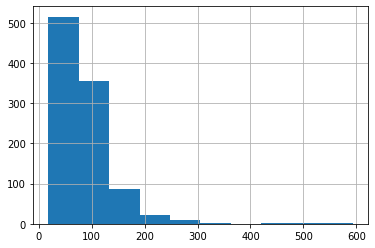

In [ ]:
#Histograma de cantidad de caracteres presentes en cada conversacion
data_sd['Conversacion'].str.len().hist()

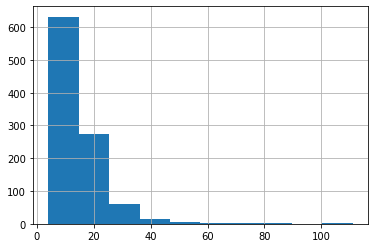

In [ ]:
#Histograma del número de palabras por cada coversacion
def numero_palabras_histogram(text):
    text.str.split().map(lambda x: len(x)).hist()
    
numero_palabras_histogram(data_sd['Conversacion'])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#Seleccion de conversaciones con mas de 2 palabras
data_new = data_sd[data_sd['Conversacion'].str.split().map(lambda x: len(x)) > 3]
#Seleccion de conversaciones con menos de 80 palabras
data_new = data_new[data_new['Conversacion'].str.split().map(lambda x: len(x)) <60]
data_new = data_new.reset_index(drop=True)
data_new.head()

,Fecha,Id,Conversacion,Area
0,18-10-2022 / 21:30:43,12392451273,Buenos días no me han dado hasta ahora mi firm...,Operaciones
1,10-10-2022 / 18:19:32,13059890172,Yo ya tengo mi firma electrónica con ustedes p...,Sistema Facturacion
2,14-10-2022 / 09:28:18,14438378825,"Buenas tardes, les saluda Lorena Sofia Carvaj...",Soporte
3,12-10-2022 / 15:45:00,14438378825,"Buenas tardes, recibi un correo para renovar l...",Renovaciones
4,17-10-2022 / 13:07:38,17862568709,"Hola, estoy intentando registrar mi firma con ...",Operaciones


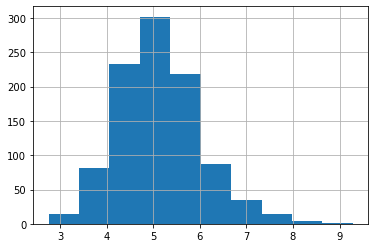

In [ ]:
#histograma de la longitud promedio de las palabras
def longitud_palabras_histogram(text):
    text.str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist()
    
longitud_palabras_histogram(data_new['Conversacion'])

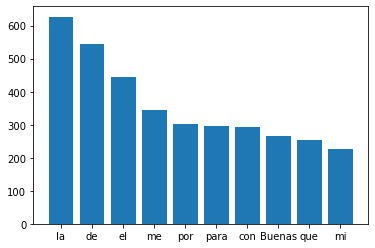

In [ ]:
stop_words = stopwords.words('spanish')
stop_words.extend(['Buenos', 'dias', 'días', 'día', 'noches', 'tardes', 'tardes,', 'Buenas','Buen','favor','buenos','buenas','buen'])
stop=set(stop_words)

#Top de los palabras vacias
def top_stopwords(text): 
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    from collections import defaultdict
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    x,y=zip(*top)
    plt.bar(x,y)

top_stopwords(data_new['Conversacion'])

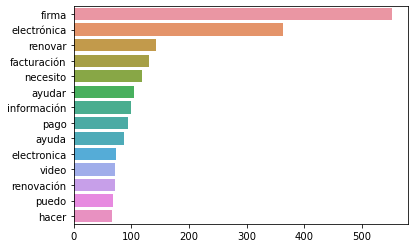

In [ ]:
#Top de los palabras que no son vacias
def top_no_stopwords(text):
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:40]:
        if (word not in stop):
            x.append(word)
            y.append(count)
    sns.barplot(x=y,y=x)
top_no_stopwords(data_new['Conversacion'])

#### Exploración de ngramas

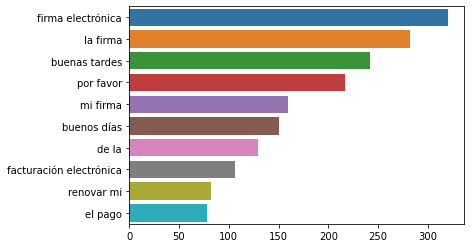

In [ ]:
#Funcion que agrupa por N-Gramas
def top_n_gramas(text, n=2):
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    def _obtener_ngramas(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]
    top_n_bigrams=_obtener_ngramas(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)
    
top_n_gramas(data_new['Conversacion'],2)

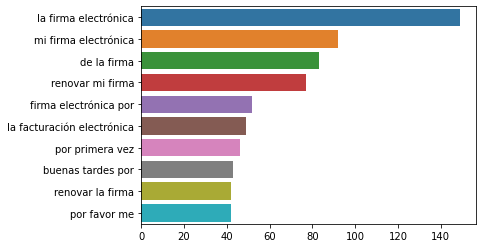

In [ ]:
top_n_gramas(data_new['Conversacion'],3)

#### Tokenizar palabras, Lemantizar y limpiar texto

In [ ]:
#Tokenizar cada oración en una lista de palabras, eliminar los signos de puntuación y los caracteres innecesarios
data = data_new.Conversacion.values.tolist()

def lista_palabras(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence).encode('utf-8'), deacc=True))  # deacc=True elimina signos de puntuacion

In [ ]:
# Funciones para stopwords, bigramas y Lemantizar
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)

nlp = spacy.load('es_core_news_md')
nlp.disable_pipes('parser', 'ner')
    
# Eliminar Stop Word
def eliminar_stopwords(texts):
    return [[word for word in gensim.utils.simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

# Formar los Bigramas
def crear_bigramas(texts):
    return [bigram_mod[doc] for doc in texts]

# Lemantizar
def lemantizar(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:

data_no_stopword = eliminar_stopwords(data_words)


data_bigrama = crear_bigramas(data_no_stopword)

# Lemantizar solo con noun, adj, vb, adv
nlp = spacy.load('es_core_news_md')
nlp.disable_pipes('parser', 'ner')
data_lemantizada = lemantizar(data_bigrama, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [ ]:
def tratamiento_data(text):
    #lista palabras
    data_words = list(lista_palabras(text))
    #Limpiar stopword
    data_no_stopword = eliminar_stopwords(data_words)
    #Crear bigramas
    data_bigrama = crear_bigramas(data_no_stopword)

    # Lemantizar solo con noun, adj, vb, adv
    data_lemantizada = lemantizar(data_bigrama, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    return data_lemantizada

In [ ]:
data_lemantizada = tratamiento_data(data)

#### Creacion de Corpus y Diccionario

In [ ]:
# Creacion de  Diccionario
id2word = gensim.corpora.Dictionary(data_lemantizada)

# Creacion de Corpus
corpus = [id2word.doc2bow(text) for text in data_lemantizada]

#### Modelo LDA o MALLET y numero de temas optimos

In [ ]:
#Funcion que calcula y guarda los valores de coherencia para dierentes temas con el modelo LDA
def valores_coherencia(diccionario, corpus, texts, fin, inicio=2, paso=3, tip_model='LDA'):
    coherencia_val = []
    modelos = []
    for num_temas in range(inicio, fin, paso):
        if (tip_model == 'LDA') :
            model = gensim.models.ldamodel.LdaModel(corpus=corpus,    #corpus
                                               id2word=id2word,       #diccionario
                                               num_topics=num_temas,  #numero de temas
                                               random_state=100,      
                                               update_every=1,        #frecuencia de actualización de parámetros
                                               chunksize=100,         #número de documentos por fragmento
                                               passes=10,             #pasos de entrenamiento
                                               alpha='auto',
                                               per_word_topics=True)
        else:
            model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_temas, id2word=id2word)
        modelos.append(model)
        coherencia_modelo = CoherenceModel(model=model, texts=texts, dictionary=diccionario, coherence='c_v')
        coherencia_val.append(coherencia_modelo.get_coherence())

    return modelos, coherencia_val

In [ ]:
#Calcular varios modelos y su coherencia para determinar el optimo
inicio=2
fin=18
pasos=2
modelos, coherencia_val = valores_coherencia(diccionario=id2word, corpus=corpus, texts=data_lemantizada, inicio=inicio, fin=fin, paso=pasos,tip_model='LDA')

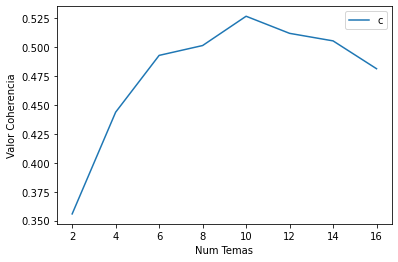

In [ ]:
#Graficar numeor de temas con su coherencia
x = range(inicio, fin, pasos)
plt.plot(x, coherencia_val)
plt.xlabel("Num Temas")
plt.ylabel("Valor Coherencia")
plt.legend(("coherencia"), loc='best')
plt.show()

In [ ]:
#Valores de COherencia por cada numero de tema
for m, cv in zip(x, coherencia_val):
    print("Numero de Temas =", m, " tiene un valor de coherencia de: ", round(cv, 4))

Numero de Temas = 2  tiene un valor de coherencia de:  0.3558
Numero de Temas = 4  tiene un valor de coherencia de:  0.4437
Numero de Temas = 6  tiene un valor de coherencia de:  0.4927
Numero de Temas = 8  tiene un valor de coherencia de:  0.5012
Numero de Temas = 10  tiene un valor de coherencia de:  0.5265
Numero de Temas = 12  tiene un valor de coherencia de:  0.5118
Numero de Temas = 14  tiene un valor de coherencia de:  0.5052
Numero de Temas = 16  tiene un valor de coherencia de:  0.4812


In [ ]:
# Selecciona el modelo mas optimo basado en la coherencia
modelo_numero = 4;
modelo_optimo = modelos[modelo_numero]
modelo_optimo.show_topics(formatted=False)
#print(modelo_optimo.print_topics(num_words=numero_temas))

[(0,
  [('plan', 0.13394636),
   ('indicar', 0.06434212),
   ('saludo', 0.057565935),
   ('subir', 0.04851156),
   ('proceso', 0.041087992),
   ('ayuda', 0.036932357),
   ('tiempo', 0.034186807),
   ('cuanto', 0.020268187),
   ('adjunto', 0.017470988),
   ('interesar', 0.017409714)]),
 (1,
  [('electronico', 0.20706211),
   ('firma', 0.1889067),
   ('ayudar', 0.0674557),
   ('necesitar', 0.059216723),
   ('renovar', 0.04368491),
   ('querer', 0.039148685),
   ('hacer', 0.023945631),
   ('desear', 0.020215273),
   ('facturacion', 0.018003857),
   ('sacar', 0.01400724)]),
 (2,
  [('gracias', 0.061278824),
   ('paso', 0.050787646),
   ('nombre', 0.04612708),
   ('paquete', 0.043877948),
   ('tambien', 0.041561462),
   ('estimado', 0.034342837),
   ('tramite', 0.03339626),
   ('consulta', 0.03228281),
   ('agradecer', 0.021393348),
   ('recibi', 0.019375365)]),
 (3,
  [('factura', 0.13289529),
   ('contar', 0.05602008),
   ('cuenta', 0.043513365),
   ('electronica', 0.04282351),
   ('inter

#### Exploración de modelado de temas con pyLDAvis

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(modelo_optimo, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.437615  0.051680       1        1  49.288769
4      0.017078 -0.295690       2        1   8.583580
3     -0.031027  0.160028       3        1   8.452218
0     -0.051190  0.092835       4        1   6.619176
6     -0.088562  0.094411       5        1   5.870066
5     -0.075427  0.020935       6        1   5.632515
9     -0.005279 -0.101470       7        1   4.856100
2     -0.069364 -0.005000       8        1   4.493099
7     -0.071442 -0.011319       9        1   4.217579
8     -0.062402 -0.006410      10        1   1.986899, topic_info=            Term        Freq       Total Category  logprob  loglift
2    electronico  550.000000  550.000000  Default  30.0000  30.0000
3          firma  502.000000  502.000000  Default  29.0000  29.0000
51          pago   84.000000   84.000000  Default  28.0000  28.0000
57         video   50.000000   50.000000  Default  27.0000  27.0000
58       factura   61.000000   61.000000  Default  26.0000  26.0000
..           ...         ...         ...      ...      ...      ...
597    enseguida    0.521634    1.244835  Topic10  -5.3249   3.0488
618        caber    0.521485    1.244748  Topic10  -5.3252   3.0486
620     urgencia    0.521485    1.244748  Topic10  -5.3252   3.0486
629        fvaor    0.521242    1.244436  Topic10  -5.3256   3.0484
850        marco    1.476827    3.977142  Topic10  -4.2842   2.9279

[352 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
813       7  0.759691    abrir
353       7  0.945474   acabar
228       1  0.973677  acceder
208       5  0.884345   acceso
102       1  0.949506   acerca
...     ...       ...      ...
270       4  0.925484      vez
57        7  0.987900    video
558       5  0.794226  vigente
675       2  0.885137   volver
556       8  0.841128      web

[325 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 4, 1, 7, 6, 10, 3, 8, 9])

#### Conversacion que contribuyo mas a un tema

In [ ]:
def temas_conversacion(ldamodel=modelo_optimo, corpus=corpus, texts=data, tip_model='LDA'):
    data_por_temas = pd.DataFrame()
    # Obtener tema por cada conversacion
    for i, row in enumerate(ldamodel[corpus]):
        if tip_model == 'LDA':
            row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        else:
            row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Obtener el tema dominante por cada conversacion
        for j, (num_tema, tem_pro) in enumerate(row):
            if j == 0:
                wp = ldamodel.show_topic(num_tema)
                palabras_tema = ", ".join([word for word, prop in wp])
                data_por_temas = data_por_temas.append(pd.Series([int(num_tema), round(tem_pro,4), palabras_tema]), ignore_index=True)
            else:
                break
    data_por_temas.columns = ['Tema_Dominante', 'Porce_Contribucion', 'Palabras_tema']
    contents = pd.Series(texts)
    data_por_temas = pd.concat([data_por_temas, contents], axis=1)
    return(data_por_temas)


df_temas_palabras = temas_conversacion(ldamodel=modelo_optimo, corpus=corpus, texts=data, tip_model='LDA')

# Formatear el Dataframe
df_tema_dominante = df_temas_palabras.reset_index()
df_tema_dominante.columns = ['Document_No', 'Tema_Dominante', 'Porce_Contribucion', 'Palabras', 'Texto']

df_tema_dominante.head()

,Document_No,Tema_Dominante,Porce_Contribucion,Palabras,Texto
0,0,1.0,0.4401,"electronico, firma, ayudar, necesitar, renovar...",Buenos días no me han dado hasta ahora mi firm...
1,1,1.0,0.7592,"electronico, firma, ayudar, necesitar, renovar...",Yo ya tengo mi firma electrónica con ustedes p...
2,2,1.0,0.4528,"electronico, firma, ayudar, necesitar, renovar...","Buenas tardes, les saluda Lorena Sofia Carvaj..."
3,3,1.0,0.6965,"electronico, firma, ayudar, necesitar, renovar...","Buenas tardes, recibi un correo para renovar l..."
4,4,3.0,0.4780,"factura, contar, cuenta, electronica, interesa...","Hola, estoy intentando registrar mi firma con ..."


In [ ]:
#Conversacion principal por cada tema
temas_conver_relevante = pd.DataFrame()
temas_agrupados_conv = df_temas_palabras.groupby('Tema_Dominante')

for i, grp in temas_agrupados_conv:
    temas_conver_relevante = pd.concat([temas_conver_relevante, grp.sort_values(['Porce_Contribucion'], ascending=[0]).head(1)], axis=0)
   
temas_conver_relevante.reset_index(drop=True, inplace=True)
temas_conver_relevante.columns = ['Numero_Tema', "Porce_Contribucion", "Palabras", "Texto"]
temas_conver_relevante
temas_conver_relevante

#### Distribucion de los temas

In [ ]:
# Nunmero de conversaciones por tema
conteo_temas = df_temas_palabras['Tema_Dominante'].value_counts()

# Porcentaje de coversaciones por tema
contribucion_temas = round(conteo_temas/conteo_temas.sum(), 4)

# Numero de Tema y palabras
num_tema_palabras = temas_conver_relevante[['Numero_Tema', 'Palabras']]

df_tema_dominante = pd.concat([num_tema_palabras, conteo_temas, contribucion_temas], axis=1)
df_tema_dominante.columns = ['Tema_Dominante', 'Palabras_tema', 'Num_Conversaciones', 'Porce_Conversaciones']
df_tema_dominante

#### Nube de palabras

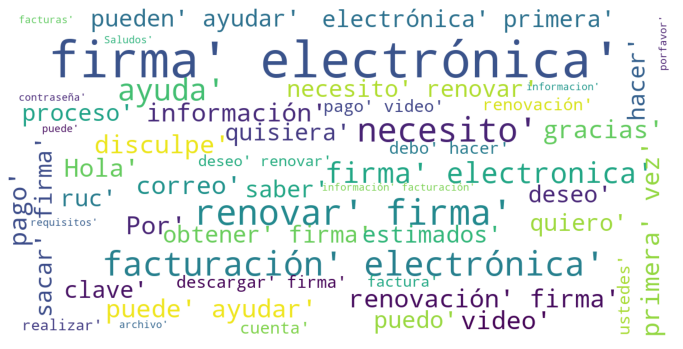

In [ ]:
def nube_palabras(texto):
    def procesar_datos(texto):
        corpus=[]
        stem=PorterStemmer()
        lem=WordNetLemmatizer()
        for conver in texto:
            palabras=[w for w in word_tokenize(conver) if (w not in stop)]
            palabras=[lem.lemmatize(w) for w in palabras if len(w)>2]
            corpus.append(palabras)
        return corpus
    
    corpus=procesar_datos(texto)
    
    nubePalabras = WordCloud(
        background_color='white',
        stopwords=set(stop),
        max_words=50,
        max_font_size=30, 
        scale=3,
        random_state=1)
    
    nubePalabras=nubePalabras.generate(str(corpus))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    plt.imshow(nubePalabras)
    plt.show()
    
nube_palabras(data_new['Conversacion'])

### Proceso para Comentarios

#### Lectura de Datos

In [ ]:
data_sd_com = pd.read_excel("dataSDCom.xlsx")
data_sd_com.head()

,cedula,nombres,Calificacion,Comentario,fecha,Polaridad
0,1721604237,VINICIO DAVID DOMINGUEZ JARAMILLO,5,Buen Servicio,2022-08-18 11:36:51,Positivo
1,1900638915,JENNIFFER PAOLA GONZALEZ VALLADARES,4,se pueda abrir con cualquier navegador,2022-08-18 11:20:55,Neutro
2,907680607,GABRIEL LEONIDAS PINO NEGRON,3,"No me gusto hacer el video, es mucho tramite",2022-08-18 10:58:54,Negativo
3,1712714870,JIMENA DEL ROCIO PAEZ LALVAY,5,Todo muy bien gracias,2022-08-18 10:56:18,Positivo
4,1002536793,LUIS ANIBAL LOPEZ CHAMORRO,3,La atencion por whatsapp es muy mala,2022-08-18 10:52:49,Negativo


In [ ]:
def anali_senti_textblob(text):
    try:
        x = TextBlob(text).translate(from_lang='es', to='en')
        x = x.sentiment.polarity
        if x<0:
            return 'Negativo'
        elif x==0:
            return 'Neutro'
        else:
            return 'Positivo'
    except:
        return ''

def analisis_sentimiento(text):
    analisis_senti = text.map(lambda x: anali_senti_textblob(x))
    #plt.bar(analisis_senti.value_counts().index,analisis_senti.value_counts())
    return analisis_senti

In [ ]:
resultado_analisis = analisis_sentimiento(data_sd_com['Comentario'])

#### Analisis de Sentimiento

<ipython-input-282-91a3294d9187>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_senti['Analisis_Senti'] = resultado_analisis


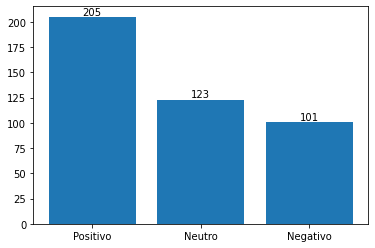

In [ ]:
data_senti = data_sd_com[['Comentario','Polaridad']]
data_senti['Analisis_Senti'] = resultado_analisis
data_senti = data_senti[data_senti.Analisis_Senti != '']
plt.bar(data_senti.Analisis_Senti.value_counts().index,data_senti.Analisis_Senti.value_counts())
for x, y in zip(data_senti.Analisis_Senti.value_counts().index, data_senti.Analisis_Senti.value_counts()):
    plt.text(x, y, '%i' % y, ha='center', va='bottom')

#### Evaluacion del modulo de analisis de sentimiento

In [ ]:
def plot_confusion_matrix(matriz_conf, classes,
                          title='Matriz de Confusion',
                          cmap=plt.cm.Blues):
    plt.imshow(matriz_conf, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    print(matriz_conf)

    thresh = matriz_conf.max() / 2.
    for i, j in itertools.product(range(matriz_conf.shape[0]), range(matriz_conf.shape[1])):
        plt.text(j, i, matriz_conf[i, j],
                 horizontalalignment="center",
                 color="white" if matriz_conf[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Valor real')
    plt.xlabel('Valor predicho')

[[ 89   8   9]
 [ 10  96  20]
 [  2  19 176]]


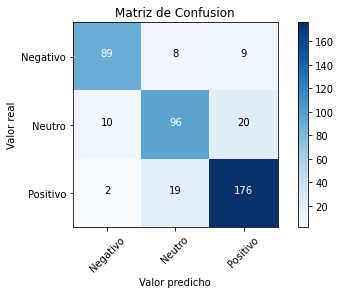

In [ ]:
plot_confusion_matrix(metrics.confusion_matrix(data_senti['Polaridad'], data_senti['Analisis_Senti']), classes=["Negativo","Neutro","Positivo"])

In [ ]:
print(metrics.classification_report(data_senti['Polaridad'], data_senti['Analisis_Senti']))

              precision    recall  f1-score   support

    Negativo       0.88      0.84      0.86       106
      Neutro       0.78      0.76      0.77       126
    Positivo       0.86      0.89      0.88       197

    accuracy                           0.84       429
   macro avg       0.84      0.83      0.84       429
weighted avg       0.84      0.84      0.84       429



#### Lectura de Comentarios Negativos

In [ ]:
data_nega = data_senti[(data_senti.Analisis_Senti == 'Negativo')]
data_nega.head()

,Comentario,Polaridad,Analisis_Senti
4,La atencion por whatsapp es muy mala,Negativo,Negativo
8,"menos tramitologia, se demoran mucho los proce...",Negativo,Negativo
9,Deben recomendar a los usuarios usar el navega...,Negativo,Negativo
14,"no son nada atentos los operadores, su trato f...",Negativo,Negativo
16,UN POCO EL ALTO EL VALOR PARA CINCO ANIOS,Negativo,Negativo


#### Analisis Estadistico

<AxesSubplot:>

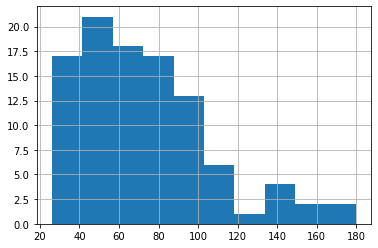

In [ ]:
#Histograma de cantidad de caracteres presentes en cada conversacion
data_nega['Comentario'].str.len().hist()

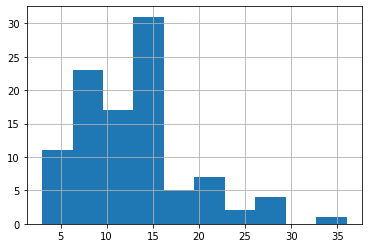

In [ ]:
#Histograma del número de palabras por cada coversacion  
numero_palabras_histogram(data_nega['Comentario'])

In [ ]:
#Seleccion de comentarios con mas de 2 palabras
data_nega = data_nega[data_nega['Comentario'].str.split().map(lambda x: len(x)) > 3]
#Seleccion de comentarios con menos de 80 palabras
data_nega = data_nega[data_nega['Comentario'].str.split().map(lambda x: len(x)) <60]
data_nega = data_nega.reset_index(drop=True)
data_nega.to_excel('negativo.xlsx')
data_nega.head()

,Comentario,Polaridad,Analisis_Senti
0,La atencion por whatsapp es muy mala,Negativo,Negativo
1,"menos tramitologia, se demoran mucho los proce...",Negativo,Negativo
2,Deben recomendar a los usuarios usar el navega...,Negativo,Negativo
3,"no son nada atentos los operadores, su trato f...",Negativo,Negativo
4,UN POCO EL ALTO EL VALOR PARA CINCO ANIOS,Negativo,Negativo


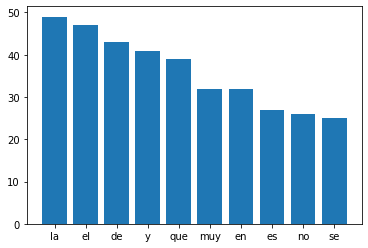

In [ ]:
top_stopwords(data_nega['Comentario'])

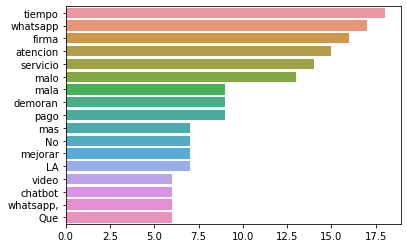

In [ ]:
top_no_stopwords(data_nega['Comentario'])

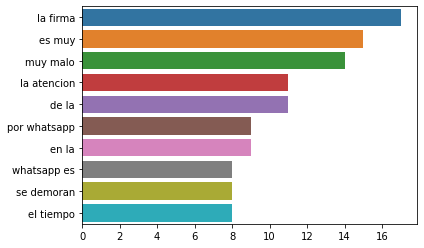

In [ ]:
top_n_gramas(data_nega['Comentario'],2)

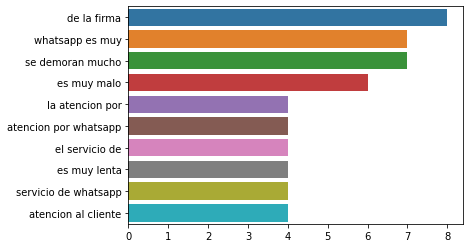

In [ ]:
top_n_gramas(data_nega['Comentario'],3)

In [ ]:
#Tokenizar cada oración en una lista de palabras, eliminar los signos de puntuación, los caracteres innecesarios y lemantizar
data = data_nega.Comentario.values.tolist()
data_lemantizada = tratamiento_data(data)

In [ ]:
# Creacion de  Diccionario
id2word = gensim.corpora.Dictionary(data_lemantizada)

# Creacion de Corpus
corpus = [id2word.doc2bow(text) for text in data_lemantizada]

#### Creacion de Modelo Mallet

In [ ]:
import os
os.environ.update({'MALLET_HOME':r'C:/new_mallet/mallet-2.0.8/'})
mallet_path = 'C:/new_mallet/mallet-2.0.8/bin/mallet' # actualizar esta ruta

In [ ]:
#Calcular varios modelos y su coherencia para determinar el optimo
inicio=2
fin=10
pasos=2
modelos, coherencia_val = valores_coherencia(diccionario=id2word, corpus=corpus, texts=data_lemantizada, inicio=inicio, fin=fin, paso=pasos, tip_model = 'MALLET')

#### Seleccion del numero de temas

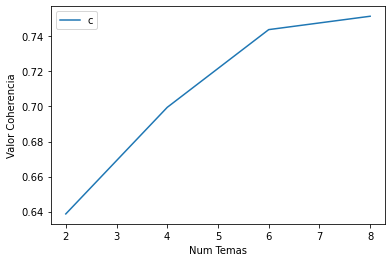

In [ ]:
#Graficar numeor de temas con su coherencia
x = range(inicio, fin, pasos)
plt.plot(x, coherencia_val)
plt.xlabel("Num Temas")
plt.ylabel("Valor Coherencia")
plt.legend(("coherencia"), loc='best')
plt.show()

In [ ]:
#Valores de COherencia por cada numero de tema
for m, cv in zip(x, coherencia_val):
    print("Numero de Temas =", m, " tiene un valor de coherencia de: ", round(cv, 4))

Numero de Temas = 2  tiene un valor de coherencia de:  0.6387
Numero de Temas = 4  tiene un valor de coherencia de:  0.6995
Numero de Temas = 6  tiene un valor de coherencia de:  0.7439
Numero de Temas = 8  tiene un valor de coherencia de:  0.7515


In [ ]:
# Selecciona el modelo mas optimo basado en la coherencia
modelo_numero = 2;
modelo_optimo = modelos[modelo_numero]
modelo_optimo.show_topics(formatted=False)

[(0,
  [('malo', 0.34615384615384615),
   ('servicio', 0.11538461538461539),
   ('tramite', 0.05128205128205128),
   ('pesimo', 0.038461538461538464),
   ('proceso', 0.038461538461538464),
   ('personalizar', 0.01282051282051282),
   ('eliminar', 0.01282051282051282),
   ('respuesta', 0.01282051282051282),
   ('corregir', 0.01282051282051282),
   ('relevo', 0.01282051282051282)]),
 (1,
  [('menos', 0.06097560975609756),
   ('video', 0.06097560975609756),
   ('realizar', 0.04878048780487805),
   ('rapidez', 0.04878048780487805),
   ('rapido', 0.04878048780487805),
   ('tiempo', 0.036585365853658534),
   ('paso', 0.036585365853658534),
   ('quitar', 0.036585365853658534),
   ('persona', 0.036585365853658534),
   ('revisar', 0.024390243902439025)]),
 (2,
  [('mas', 0.14864864864864866),
   ('responder', 0.0945945945945946),
   ('perder', 0.06756756756756757),
   ('respuesta', 0.04054054054054054),
   ('perdido', 0.04054054054054054),
   ('problema', 0.02702702702702703),
   ('mal', 0.0270

In [ ]:
df_temas_palabras = temas_conversacion(ldamodel=modelo_optimo, corpus=corpus, texts=data, tip_model = 'MALLET')

# Formatear el Dataframe
df_tema_dominante = df_temas_palabras.reset_index()
df_tema_dominante.columns = ['Document_No', 'Tema_Dominante', 'Porce_Contribucion', 'Palabras', 'Texto']

df_tema_dominante.head()

,Document_No,Tema_Dominante,Porce_Contribucion,Palabras,Texto
0,0,0.0,0.1667,"malo, servicio, tramite, pesimo, proceso, pers...",La atencion por whatsapp es muy mala
1,1,1.0,0.1749,"menos, video, realizar, rapidez, rapido, tiemp...","menos tramitologia, se demoran mucho los proce..."
2,2,1.0,0.2259,"menos, video, realizar, rapidez, rapido, tiemp...",Deben recomendar a los usuarios usar el navega...
3,3,5.0,0.1934,"firma, mejorar, lento, atendar, tratar, descar...","no son nada atentos los operadores, su trato f..."
4,4,3.0,0.1887,"pago, precio, hacer, cliente, alto, bajar, car...",UN POCO EL ALTO EL VALOR PARA CINCO ANIOS


In [ ]:
#Conversacion principal por cada tema
temas_conver_relevante = pd.DataFrame()
temas_agrupados_conv = df_temas_palabras.groupby('Tema_Dominante')

for i, grp in temas_agrupados_conv:
    temas_conver_relevante = pd.concat([temas_conver_relevante, grp.sort_values(['Porce_Contribucion'], ascending=[0]).head(1)], axis=0)
   
temas_conver_relevante.reset_index(drop=True, inplace=True)
temas_conver_relevante.columns = ['Numero_Tema', "Porce_Contribucion", "Palabras", "Texto"]
temas_conver_relevante

,Numero_Tema,Porce_Contribucion,Palabras,Texto
0,0.0,0.2184,"malo, servicio, tramite, pesimo, proceso, pers...","Muy malo el chatbot de Whatsapp, necesitan mej..."
1,1.0,0.2361,"menos, video, realizar, rapidez, rapido, tiemp...",En su call center no contestan se realizaron m...
2,2.0,0.2171,"mas, responder, perder, respuesta, perdido, pr...",Mas amabilidad al atender el asesor que me ate...
3,3.0,0.2384,"pago, precio, hacer, cliente, alto, bajar, car...","BAJAR COSTOS, LOS PRECIOS SON MUY ALTOS y CAROS"
4,4.0,0.2280,"tiempo, demorar, contestar, descargo, duda, pe...",no cumplen con el tiempo que indican en revisa...
5,5.0,0.2149,"firma, mejorar, lento, atendar, tratar, descar...",Deben informar que para descargar el archivo d...


In [ ]:
# Nunmero de conversaciones por tema
conteo_temas = df_temas_palabras['Tema_Dominante'].value_counts()

# Porcentaje de coversaciones por tema
contribucion_temas = round(conteo_temas/conteo_temas.sum(), 4)

# Numero de Tema y palabras
num_tema_palabras = temas_conver_relevante[['Numero_Tema', 'Palabras']]

df_tema_dominante = pd.concat([num_tema_palabras, conteo_temas, contribucion_temas], axis=1)
df_tema_dominante.columns = ['Tema_Dominante', 'Palabras_tema', 'Num_Conversaciones', 'Porce_Conversaciones']
df_tema_dominante

,Tema_Dominante,Palabras_tema,Num_Conversaciones,Porce_Conversaciones
0.0,0.0,"malo, servicio, tramite, pesimo, proceso, pers...",22,0.2222
1.0,1.0,"menos, video, realizar, rapidez, rapido, tiemp...",18,0.1818
2.0,2.0,"mas, responder, perder, respuesta, perdido, pr...",13,0.1313
3.0,3.0,"pago, precio, hacer, cliente, alto, bajar, car...",15,0.1515
4.0,4.0,"tiempo, demorar, contestar, descargo, duda, pe...",19,0.1919
5.0,5.0,"firma, mejorar, lento, atendar, tratar, descar...",12,0.1212


### Modulo de clasificacion de mensajes

In [ ]:
data_new.head()

,Fecha,Id,Conversacion,Area
0,18-10-2022 / 21:30:43,12392451273,Buenos días no me han dado hasta ahora mi firm...,Operaciones
1,10-10-2022 / 18:19:32,13059890172,Yo ya tengo mi firma electrónica con ustedes p...,Sistema Facturacion
2,14-10-2022 / 09:28:18,14438378825,"Buenas tardes, les saluda Lorena Sofia Carvaj...",Soporte
3,12-10-2022 / 15:45:00,14438378825,"Buenas tardes, recibi un correo para renovar l...",Renovaciones
4,17-10-2022 / 13:07:38,17862568709,"Hola, estoy intentando registrar mi firma con ...",Operaciones


In [ ]:
data_new["Area"].value_counts()

Operaciones            325
Renovaciones           237
Sistema Facturacion    236
Soporte                193
Name: Area, dtype: int64

In [ ]:
import string
punctuation = set(string.punctuation)
def tokenizar(oracion):
    tokens = []
    for token in oracion.split():
        token_nw = []
        for character in token:
            if character not in punctuation:
                token_nw.append(character.lower())
        if token_nw:
            tokens.append("".join(token_nw))
    return tokens

In [ ]:
data_new.head()["Conversacion"].apply(tokenizar)

0    [buenos, días, no, me, han, dado, hasta, ahora...
1    [yo, ya, tengo, mi, firma, electrónica, con, u...
2    [buenas, tardes, les, saluda, lorena, sofia, c...
3    [buenas, tardes, recibi, un, correo, para, ren...
4    [hola, estoy, intentando, registrar, mi, firma...
Name: Conversacion, dtype: object

#### Separacion de datos de entrenamiento y test

In [ ]:
text_entrenamiento, text_test, label_entrenamiento, label_test = train_test_split(data_new['Conversacion'], data_new['Area'], stratify=data_new['Area'])
print(f"Data entrenamiento: {len(text_entrenamiento)}, Data de test: {len(text_test)}")

Data entrenamiento: 743, Data de test: 248


#### Creacion de modelo MSV

In [ ]:
vectorized = CountVectorizer(tokenizer = tokenizar, binary=True)
entrena_X = vectorized.fit_transform(text_entrenamiento)
test_X = vectorized.transform(text_test)
classifier = LinearSVC()
classifier.fit(entrena_X, label_entrenamiento)
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1500,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=10)

LinearSVC(max_iter=1500, verbose=10)

In [ ]:
predicciones = classifier.predict(test_X)

[[74  0  0  8]
 [ 2 56  0  1]
 [ 4  1 54  0]
 [ 9  1  4 34]]


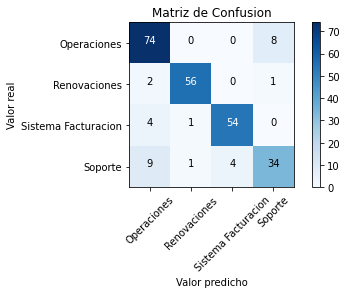

In [ ]:
plot_confusion_matrix(metrics.confusion_matrix(label_test, predicciones), classes=["Operaciones","Renovaciones","Sistema Facturacion","Soporte"])

In [ ]:
print(metrics.classification_report(label_test, predicciones))

                     precision    recall  f1-score   support

        Operaciones       0.83      0.90      0.87        82
       Renovaciones       0.97      0.95      0.96        59
Sistema Facturacion       0.93      0.92      0.92        59
            Soporte       0.79      0.71      0.75        48

           accuracy                           0.88       248
          macro avg       0.88      0.87      0.87       248
       weighted avg       0.88      0.88      0.88       248



#### Pruebas de modelo

In [ ]:
frases = [
    'Quiero saber como renovar mi firma',
    'Como obtengo mi sistema de facturacion',
    'Que hago cuando falta subir el pago',
    'No puedo descargar la firma electronica',
    'Que precios nomas tiene para facturacion electronica']

In [ ]:
frases_X = vectorized.transform(frases)
predicciones = classifier.predict(frases_X)

In [ ]:
for texto, area in zip(frases,predicciones):
    print(f"{area:5} - {texto}")

Renovaciones - Quiero saber como renovar mi firma
Sistema Facturacion - Como obtengo mi sistema de facturacion
Operaciones - Que hago cuando falta subir el pago
Soporte - No puedo descargar la firma electronica
Sistema Facturacion - Que precios nomas tiene para facturacion electronica
